In [107]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(survplot)
library(muhaz)
source("../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [108]:
df_final <- read.table("../../clustering/clustering_Final_1/df_final_full_component.tsv")
eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:186)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])

              
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb")  

In [137]:
library("muhaz")
library("magrittr")

# Uses Nelson-Aalen estimator to first get cumulative hazard, and then predict
# the hazard function from that.
colon.kphaz.fit <- 
  colon %>%
  filter(rx == "Obs") %$%
  kphaz.fit(.$time, .$status, method = "nelson")
names(colon.kphaz.fit)

[1] "time" "haz"  "var"

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


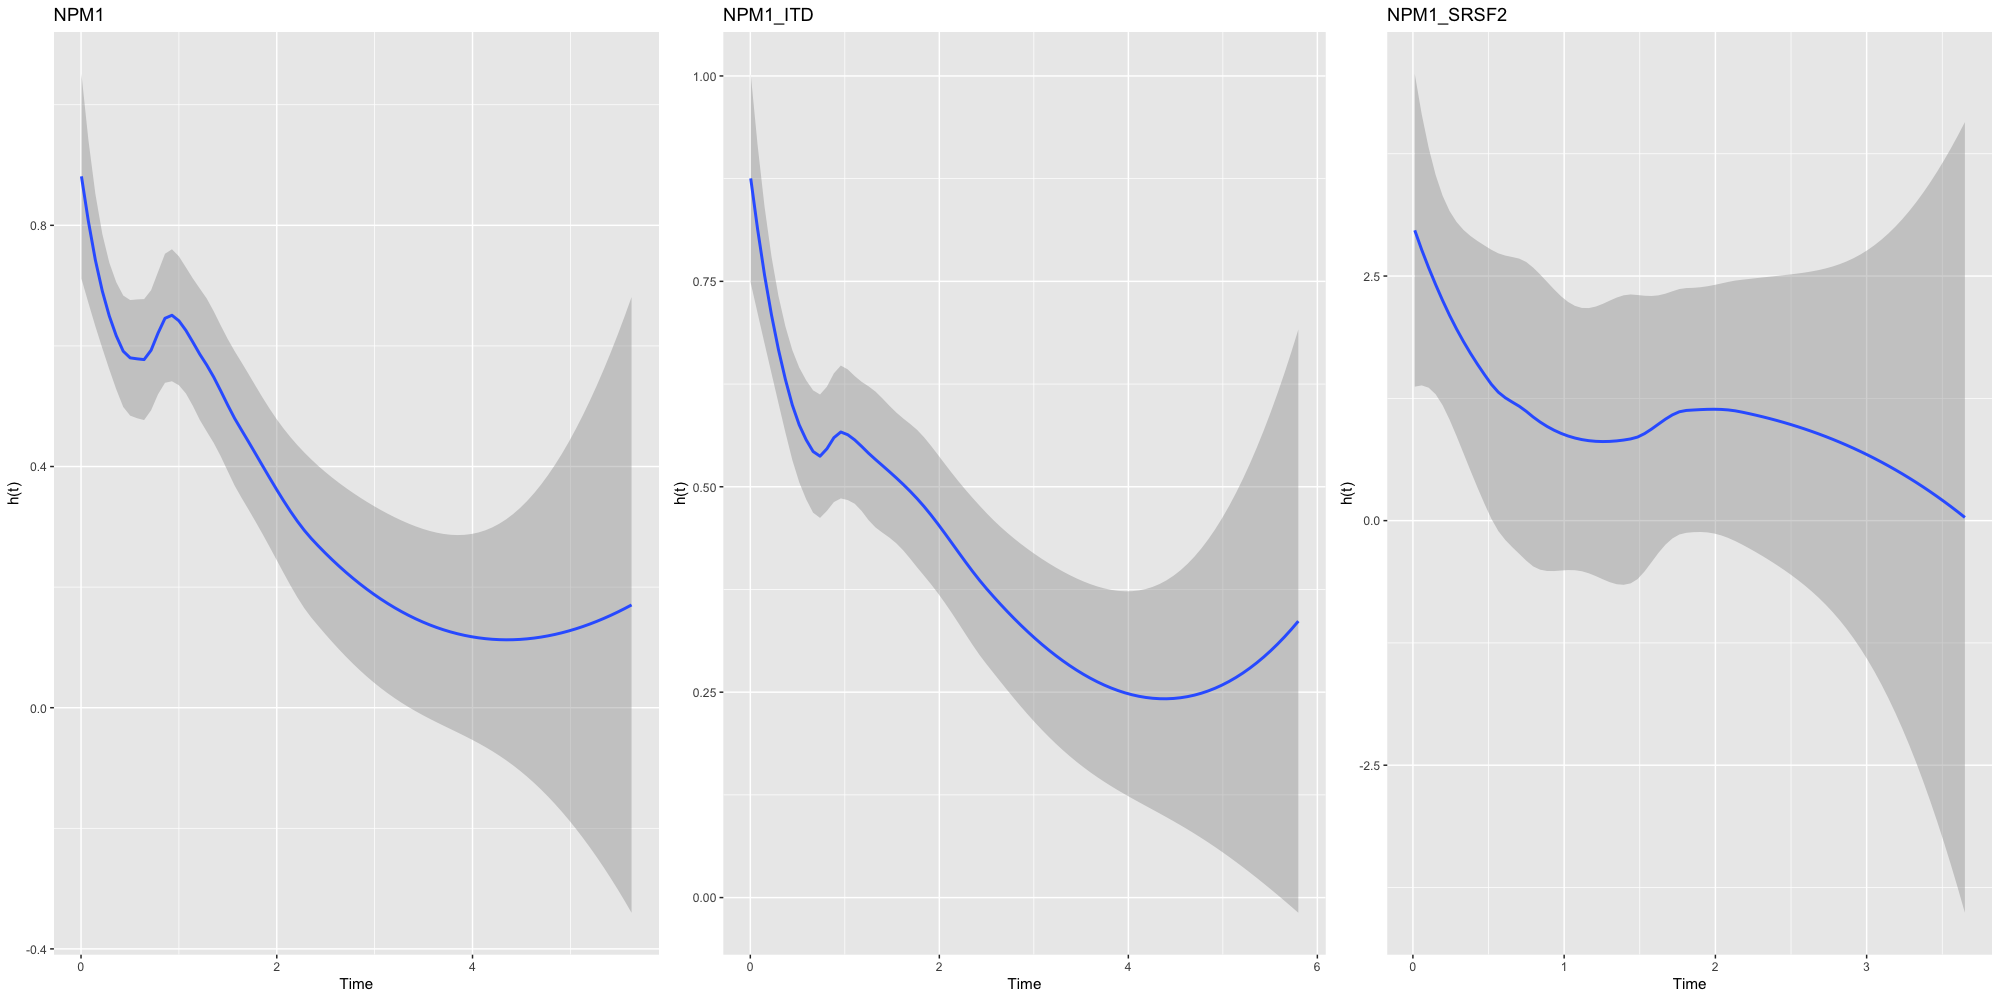

In [159]:
library(muhaz)
set_notebook_plot_size(20,10)
tmp <- df_final[df_final$NPM1==1,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
p <- fit%>%
  as.data.frame() %>%
  ggplot(aes(x = time, y = haz)) +
  geom_smooth() +
  xlab("Time") +
  ylab("h(t)")+ggtitle("NPM1")

tmp <- df_final[tmp$NPM1==1 & tmp$ITD==1,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
q <- fit%>%
  as.data.frame() %>%
  ggplot(aes(x = time, y = haz)) +
  geom_smooth() +
  xlab("Time") +
  ylab("h(t)")+ggtitle("NPM1_ITD")

tmp<- df_final
tmp <- tmp[tmp$NPM1==1 & tmp$SRSF2==1,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
r <- fit%>%
  as.data.frame() %>%
  ggplot(aes(x = time, y = haz)) +
  geom_smooth() +
  xlab("Time") +
  ylab("h(t)")+ggtitle("NPM1_SRSF2")
grid.arrange(p,q,r,ncol=3)

In [121]:
install.packages('mixPHM')


The downloaded binary packages are in
	/var/folders/r1/ym3vk99s5r53tcxqzhk93lfx07thgf/T//Rtmp0Xktho/downloaded_packages


In [123]:
library(mixPHM)
tmp <- df_final
tmp$comparison <- ifelse(tmp$NPM1==1,1,0)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
plot.hazard(fit)
# ggsurvplot(fit, pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates",palette=val,what=c("survival","hazard"),fun="cumhaz",
#               ggtheme = theme_survminer(
#              font.main = c(16, "bold", "darkblue"),
#              font.submain = c(15, "bold.italic", "purple"),
#              font.caption = c(14, "plain", "orange"),
#              font.x = c(14, "bold.italic", "red"),
#              font.y = c(14, "bold.italic", "darkred"),
#              font.tickslab = c(12, "plain", "darkgreen")))


ERROR: Error in plot.hazard(fit): could not find function "plot.hazard"


In [65]:
summary(survfit(Surv(time = tmp$os, event = tmp$os_status)~ comparison,data=tmp))

Call: survfit(formula = Surv(time = tmp$os, event = tmp$os_status) ~ 
    comparison, data = tmp)

                comparison=0 
    time n.risk n.event survival  std.err lower 95% CI upper 95% CI
 0.00274   1447       1    0.999 0.000691        0.998        1.000
 0.00548   1446       2    0.998 0.001196        0.996        1.000
 0.00821   1444       1    0.997 0.001380        0.995        1.000
 0.01369   1443       1    0.997 0.001543        0.994        1.000
 0.01643   1442       2    0.995 0.001824        0.992        0.999
 0.01916   1440       4    0.992 0.002283        0.988        0.997
 0.02190   1436       3    0.990 0.002573        0.985        0.995
 0.02464   1433       1    0.990 0.002663        0.984        0.995
 0.02738   1432       2    0.988 0.002833        0.983        0.994
 0.03012   1430       3    0.986 0.003069        0.980        0.992
 0.03285   1427       1    0.985 0.003144        0.979        0.992
 0.03559   1426       1    0.985 0.003217        0.979 

In [54]:
help(Surv)

Surv {survival},R Documentation
time,"for right censored data, this is the follow up time. For interval data, the first argument is the starting time for the interval."
event,"The status indicator, normally 0=alive, 1=dead. Other choices are TRUE/FALSE (TRUE = death) or 1/2 (2=death). For interval censored data, the status indicator is 0=right censored, 1=event at time, 2=left censored, 3=interval censored. For multiple enpoint data the event variable will be a factor, whose first level is treated as censoring. Although unusual, the event indicator can be omitted, in which case all subjects are assumed to have an event."
time2,"ending time of the interval for interval censored or counting process data only. Intervals are assumed to be open on the left and closed on the right, (start, end]. For counting process data, event indicates whether an event occurred at the end of the interval."
type,"character string specifying the type of censoring. Possible values are ""right"", ""left"", ""counting"", ""interval"", ""interval2"" or ""mstate""."
origin,"for counting process data, the hazard function origin. This option was intended to be used in conjunction with a model containing time dependent strata in order to align the subjects properly when they cross over from one strata to another, but it has rarely proven useful."
x,any R object.
